In [1]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

Cargo el dataframe completo, con los nuevos datos incluidos.

In [2]:
ruta_df =  os.path.join("..","..","..", "data", "processed","peleas.parquet")
df = pd.read_parquet(ruta_df)
df

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
0,Laverne Clark,Frank Caracci,1999-01-08,LIGHTWEIGHT,False,KO/TKO,412,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Mikey Burnett,Townsend Saunders,1999-01-08,LIGHTWEIGHT,False,Decision - Unanimous,180,2,1,0,...,0,0,1,0,0,0,0,0,0,1
2,Pedro Rizzo,Mark Coleman,1999-01-08,HEAVYWEIGHT,False,Decision - Split,180,2,0,0,...,0,0,1,0,0,0,0,0,0,1
3,Bas Rutten,Tsuyoshi Kohsaka,1999-01-08,HEAVYWEIGHT,False,KO/TKO,135,2,1,0,...,0,0,0,0,0,1,0,0,0,0
4,Evan Tanner,Darrel Gholar,1999-01-08,MIDDLEWEIGHT,False,Submission,477,1,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7921,Cortavious Romious,ChangHo Lee,2025-04-12,BANTAMWEIGHT,True,KO/TKO,228,2,0,0,...,0,0,0,1,1,0,0,0,1,0
7922,Torrez Finney,Robert Valentin,2025-04-12,MIDDLEWEIGHT,False,Decision - Split,300,3,0,0,...,0,0,1,0,0,1,0,0,0,1
7923,Brad Tavares,Gerald Meerschaert,2025-04-12,MIDDLEWEIGHT,False,Decision - Unanimous,300,3,0,0,...,0,11,14,0,5,4,0,2,5,5
7924,Martin Buday,Uran Satybaldiev,2025-04-12,HEAVYWEIGHT,False,Decision - Unanimous,300,3,0,0,...,1,0,5,0,1,0,0,0,0,1


Separo los datos antiguos de los nuevos datos

In [3]:
df["DATE"] = pd.to_datetime(df["DATE"])

# Filtra los combates después del 9 de febrero de 2025
df_antiguos = df[df["DATE"] <= "2025-02-16"]
df_nuevos = df[df["DATE"] > "2025-02-16"]
df_nuevos

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
7844,Andre Fili,Melquizael Costa,2025-03-01,FEATHERWEIGHT,True,Submission,270,1,0,0,...,0,2,8,1,3,1,3,1,5,0
7845,Nursulton Ruziboev,Eric McConico,2025-03-01,MIDDLEWEIGHT,False,KO/TKO,33,2,2,0,...,0,0,0,0,0,1,0,0,1,0
7846,Modestas Bukauskas,Rafael Cerqueira,2025-03-01,LIGHTHEAVYWEIGHT,False,KO/TKO,132,1,1,0,...,1,0,2,0,3,2,0,0,1,0
7847,Brendan Allen,Anthony Hernandez,2025-03-01,MIDDLEWEIGHT,True,Decision - Unanimous,300,3,0,0,...,7,4,4,2,2,1,0,1,2,0
7848,Rob Font,Jean Matsumoto,2025-03-01,None,False,Decision - Split,300,3,0,0,...,1,1,5,1,0,0,1,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7921,Cortavious Romious,ChangHo Lee,2025-04-12,BANTAMWEIGHT,True,KO/TKO,228,2,0,0,...,0,0,0,1,1,0,0,0,1,0
7922,Torrez Finney,Robert Valentin,2025-04-12,MIDDLEWEIGHT,False,Decision - Split,300,3,0,0,...,0,0,1,0,0,1,0,0,0,1
7923,Brad Tavares,Gerald Meerschaert,2025-04-12,MIDDLEWEIGHT,False,Decision - Unanimous,300,3,0,0,...,0,11,14,0,5,4,0,2,5,5
7924,Martin Buday,Uran Satybaldiev,2025-04-12,HEAVYWEIGHT,False,Decision - Unanimous,300,3,0,0,...,1,0,5,0,1,0,0,0,0,1


Uso como train los datos que ya teniamos, los nuevos datos obtenidos serán el conjunto de test.

In [4]:
X_train = df_antiguos.drop(columns=["WINNER","DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])
y_train = df_antiguos["WINNER"]
X_test = df_nuevos.drop(columns=["WINNER","DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])
y_test = df_nuevos["WINNER"]

Cargo el mejor modelo obtenido en la evaluación anterior.

In [5]:
mejor_xgboost = XGBClassifier(
    alpha=0,
    colsample_bytree=0.7,
    gamma=0,
    reg_lambda=1.0,
    learning_rate=0.3,
    max_depth=3,
    min_child_weight=2,
    n_estimators=200,
    scale_pos_weight=1,
    subsample=0.8,
    random_state=42
)

# Entrenar el modelo
mejor_xgboost.fit(X_train, y_train)

y_pred = mejor_xgboost.predict(X_test)

print("Reporte de clasificación xgboost_dif:")
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f"F1-score: {f1_score(y_test,y_pred)}")

Reporte de clasificación xgboost_dif:
              precision    recall  f1-score   support

       False       0.98      0.93      0.96        46
        True       0.92      0.97      0.95        36

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Accuracy: 0.9512
F1-score: 0.9459459459459459


El accuracy se mantiene similar al obtenido en la evaluación de la fase anterior. Esto nos indica que el desempeño del modelo no se ve empeorado con los nuevos datos.

In [6]:

# Crear un DataFrame para las importancias de las características
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': mejor_xgboost.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

           Feature  Importance
45         KD_DIFF    0.078748
46    SIG_STR_DIFF    0.077178
41  STR_GROUND_A_x    0.065849
43  STR_GROUND_B_x    0.060088
48    SUB_ATT_DIFF    0.058433
..             ...         ...
39  STR_CLINCH_B_x    0.002500
54      GRAPPLER_B    0.002412
30     STR_LEG_A_y    0.002410
25    STR_BODY_A_x    0.002257
29     STR_LEG_A_x    0.001940

[75 rows x 2 columns]


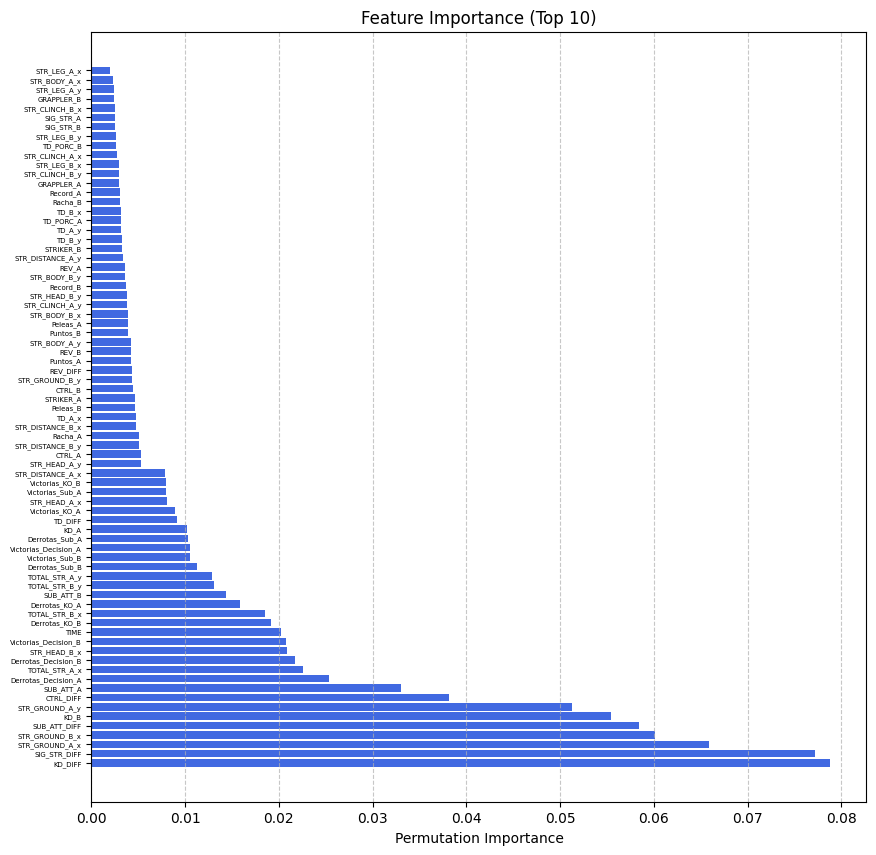

In [7]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Las importancias se mantienen similares a las que obtuvimos en la fase anterior.

In [8]:
X_train = df.drop(columns=["WINNER","DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])
y_train = df["WINNER"]

In [9]:
mejor_xgboost.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Entreno el modelo con todos los datos completos para pasarlo a producción de la forma más completa posible.

In [ ]:
mejor_xgboost.save_model("xgboost_P1.xgb")


['xgboost_P1.joblib']